In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from icecream import ic
from scipy.optimize import curve_fit
import emcee
import time

plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

# Calibrations

## Plotting functions

In [33]:
# peaks of spectra, initial guesses, helpful for later fitting
multiindex = [
    ["E", "E", "D1", "D1", "D2", "D2"],
    ["p1", "p2","p1", "p2", "p1", "p2"],
]
tuples = list(zip(*multiindex))
index = pd.MultiIndex.from_tuples(tuples, names=["Theoretical / Detector","Peak"])
source = pd.DataFrame({"na":[511,1275,480,1260,205,790],
                       "co":[1173.2,1332.5,1150,1300,700,810]}, index=index)
ic(source)
def peak(d,p,s):
    '''
    d: E, D1 or D2
    p: p1 or p2
    s: na or co
    example use: ic(peak('D1','p1','na'))
    '''
    return float(source.loc[(d,p),s])

def energyplot(data, peak1, title, peak2=None, color1='g', color2='r'):
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'Kanal'
    df['counts'] = df.loc[df['counts'] > 0]
    sns.scatterplot(x=df.index, y=df['counts'], s=3, color='k')
    plt.title(title)
    if peak2 == None:
        plt.axvline(peak1, linewidth=.5, c=color1, label=f'peak bei {peak1}')
    else:
        plt.axvline(peak1, linewidth=.5, c=color1, label=f'peak1 bei {peak1}')
        plt.axvline(peak2, linewidth=.5, c=color2, label=f'peak2 bei {peak2}')
    
    plt.legend()
    plt.savefig(f"plots/{title}.pdf")
    plt.show()

ic| source:                                na      co
            Theoretical / Detector Peak              
            E                      p1     511  1173.2
                                   p2    1275  1332.5
            D1                     p1     480  1150.0
                                   p2    1260  1300.0
            D2                     p1     205   700.0
                                   p2     790   810.0


## Total energy spectra

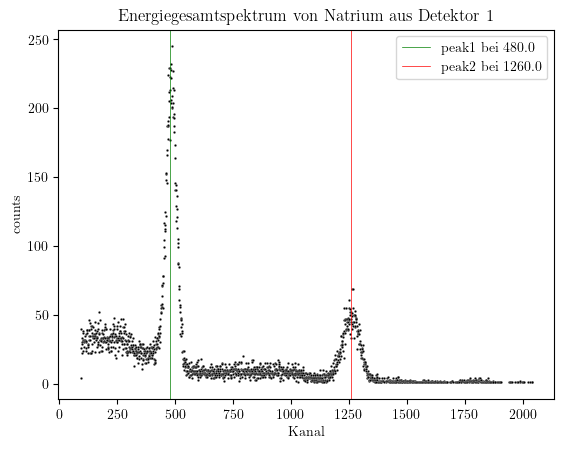

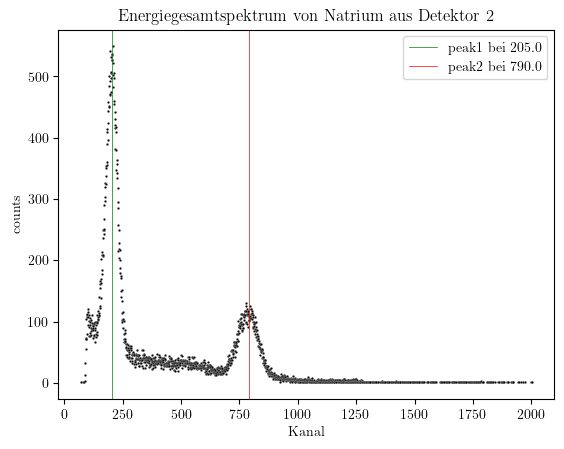

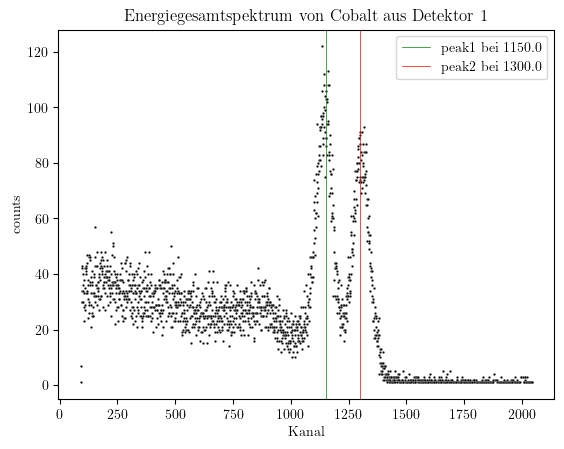

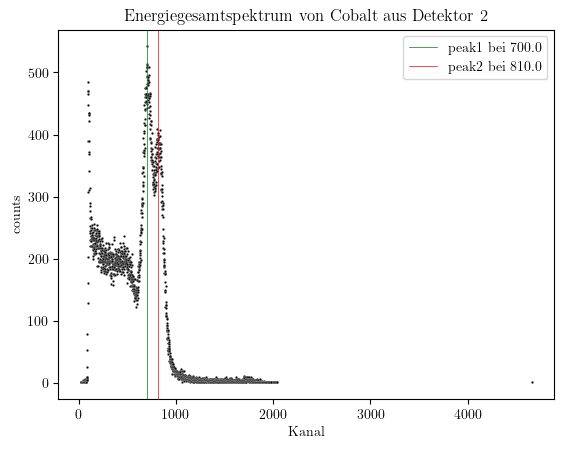

In [34]:
energyplot('Results/energiespektrum_natrium_detektor1.asc', peak('D1','p1','na'), 'Energiegesamtspektrum von Natrium aus Detektor 1', peak2=peak('D1','p2','na'))
energyplot('Results/energiespektrum_natrium_detektor2.asc', peak('D2','p1','na'), 'Energiegesamtspektrum von Natrium aus Detektor 2', peak2= peak('D2','p2','na'))
energyplot('Results/energiespektrum_cobalt_detektor1.asc', peak('D1','p1','co'), 'Energiegesamtspektrum von Cobalt aus Detektor 1', peak2=peak('D1','p2','co'))
energyplot('Results/energiespektrum_cobalt_detektor2.asc', peak('D2','p1','co'), 'Energiegesamtspektrum von Cobalt aus Detektor 2', peak2=peak('D2','p2','co'))

Detector 2 shows a very pronounced peak at lower channel values. There is a possibility that these are the peaks from compton scattering. It could however also be artifacts. \
Judging from our impression that detector 2 showed suboptimal detection accuracies at the day of experiment (cobalt peaks not pronounced well, counting rate far lower than detector 1, issues with connection to TSCA and overall equipment), we believe that these peaks are artifacts.

## Parameter fit with MCMC

### Sodium at detector 1
As our model, we choose a sum of a lognormal distribution(Compton scattering) and two gaussian distributions (511keV and 1275keV)

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/alex/.local/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Burn-in period complete
Starting chains
...Complete!
Time required:   57.75753402709961


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


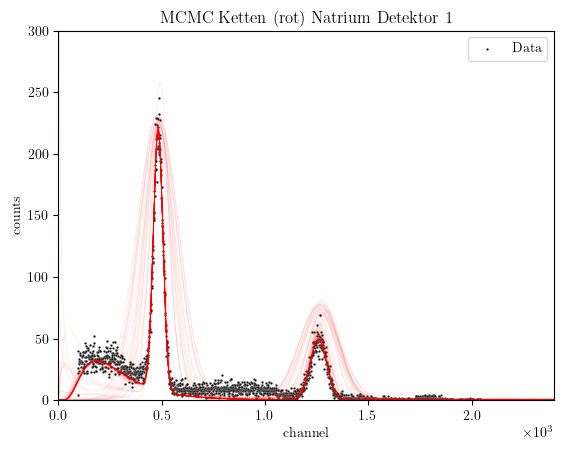

In [74]:
df = pd.read_csv('Results/energiespektrum_natrium_detektor1.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,a2,a3 = theta
    lognormal1 = np.divide(1,ch*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch)-mu1,2),2*sig1**2))
    gaussian2 = np.exp(-(ch-mu2)**2 / (2*sig2**2) )
    gaussian3 = np.exp(-(ch-mu3)**2 / (2*sig3**2) )
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 430.0 < mu2 < 530.0 and 1210.0 < mu3 < 1310.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a1 < 1e5 and 0.0 < a2 < 250.0 and 0.0 < a3 < 80:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
nwalkers = 128
niter = 500
initial = np.array([6.0, 480.0, 1260.0, 1.0, 100.0, 100.0, 10000.0, 230.0, 70.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,300])
    plt.title("MCMC Ketten (rot) Natrium Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Ketten Natrium Detektor 1.pdf")
    plt.show()

mcmcplot(sampler)

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


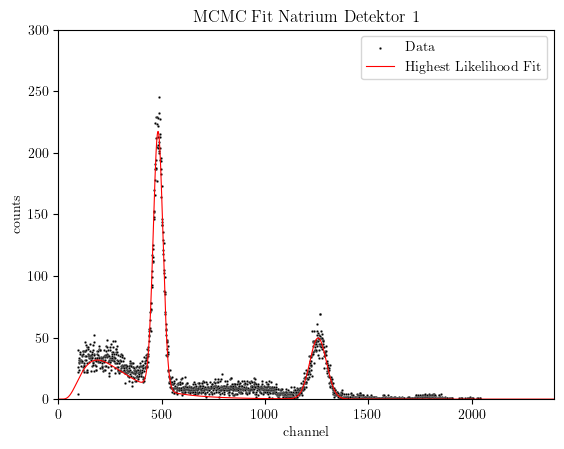

Hyperparameter: 
 [5.56517755e+00 4.82658777e+02 1.25697645e+03 5.70875131e-01
 2.32508884e+01 4.02337157e+01 1.00734626e+04 2.09145891e+02
 4.95387043e+01]


In [75]:
samples = sampler.flatchain
hyperparameter = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter)
sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,300])
plt.title("MCMC Fit Natrium Detektor 1")
plt.legend()
plt.savefig("plots/MCMC Fit Natrium Detektor 1.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter)

### Sodium at detector 2
Same model as before: one lognormal distribution and two gaussian distributions

In [ ]:
df = pd.read_csv('Results/energiespektrum_natrium_detektor2.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,a2,a3 = theta
    lognormal1 = np.divide(1,ch*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch)-mu1,2),2*sig1**2))
    gaussian2 = np.exp(-(ch-mu2)**2 / (2*sig2**2) )
    gaussian3 = np.exp(-(ch-mu3)**2 / (2*sig3**2) )
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 155.0 < mu2 < 255.0 and 720.0 < mu3 < 780.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a1 < 1e5 and 0.0 < a2 < 250.0 and 0.0 < a3 < 80:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
nwalkers = 128
niter = 500
initial = np.array([6.0, 480.0, 1260.0, 1.0, 100.0, 100.0, 10000.0, 230.0, 70.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,600])
    plt.title("MCMC Ketten (rot) Natrium Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Ketten Natrium Detektor 1.pdf")
    plt.show()

mcmcplot(sampler)

## Selected energy window spectra

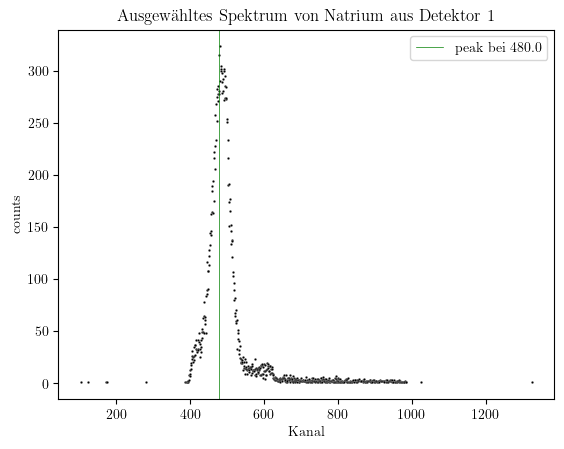

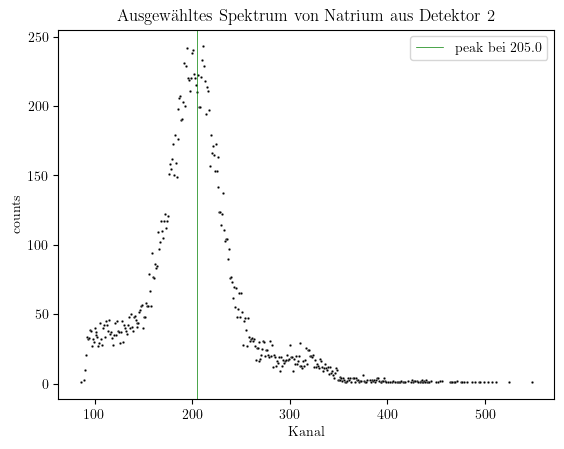

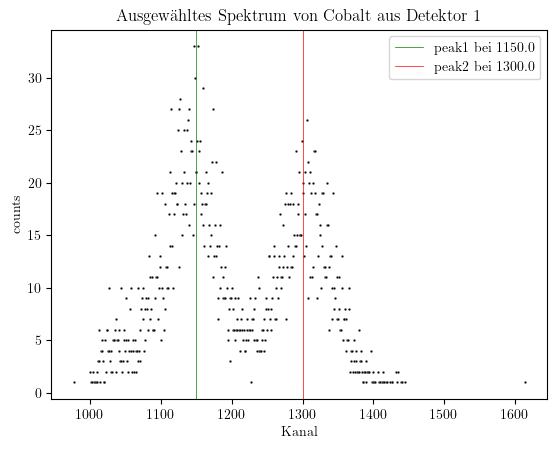

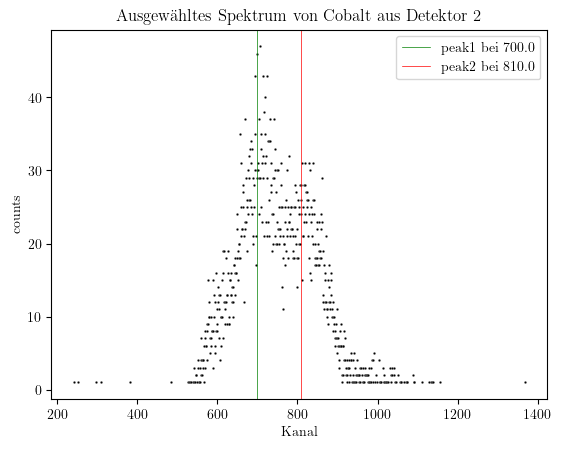

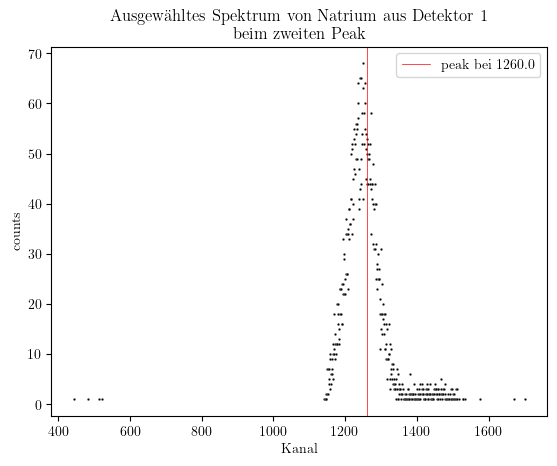

In [36]:
energyplot('Results/energieselektion_natrium_detektor1.asc', peak('D1','p1','na'), 'Ausgewähltes Spektrum von Natrium aus Detektor 1')
energyplot('Results/energieselektion_natrium_detektor2.asc', peak('D2','p1','na'), 'Ausgewähltes Spektrum von Natrium aus Detektor 2')
energyplot('Results/energieselektion_cobalt_detektor1.asc', peak('D1','p1','co'), 'Ausgewähltes Spektrum von Cobalt aus Detektor 1', peak2=peak('D1','p2','co'))
energyplot('Results/energieselektion_cobalt_detektor2.asc', peak('D2','p1','co'), 'Ausgewähltes Spektrum von Cobalt aus Detektor 2', peak2=peak('D2','p2','co'))
energyplot('Results/energieselektion_natrium_detektor1_gamma-peak.asc', peak('D1','p2','na'), 'Ausgewähltes Spektrum von Natrium aus Detektor 1 \n beim zweiten Peak', color1='r')

Despite looking at the same source and detector, the measurement of the peaks show a slightly different peak than the measurement of the complete spectra, \
I.e. the peak2 of sodium at detector 1 lies at 1260 for the complete spectrum measurement, but lies at 1250 for the selection measurement
This means that a rerun will give different results. The difference is tiny, but noticeable.

## Linear regression of the peaks $\&$ energy calibration

Detector|sodium 511keV|sodium 1275keV|cobalt 1173.2keV|cobalt 1332.5keV|
:-|-|-|-|-|
D1|480|1260|1150|1300|
D2|205|790|700|810|

We capitalize on the fact that the channel value of the TSCA is linear proportional to the energy values to an accuracy of 1keV ["Grundlagen_gamma_FP16" page 46]:
$$
    E_\gamma = a + b \cdot K .
$$
This means that the difference in energies should be the same as the difference in channel values to a factor $b$ 
\begin{align}
    \Delta E_{\gamma} &= b \Delta K \\
    b &= \frac{\Delta E_{\gamma}}{\Delta K}
\end{align}
For the difference, we use the two peaks of the spectra. In theory, a third peak should arise from compton scattering, which could increase the precision of our calibration. But those peaks were hard to observe. In case of detector 2, we don't know for sure whether the peak at lower channel values is physical or not just some artifact. \
We can determine $a$ by inserting any matching pair of channel value and energy peak, i.e. 480 and 511 for sodium at detector 1.

In [37]:
source

na      co
Theoretical / Detector Peak              
E                      p1     511  1173.2
                       p2    1275  1332.5
D1                     p1     480  1150.0
                       p2    1260  1300.0
D2                     p1     205   700.0
                       p2     790   810.0

ic| calibration:                                     na          co
                 Detector Calibration value                        
                 D1       a                   40.846154  -48.100000
                          b                    0.979487    1.062000
                 D2       a                  243.273504  159.472727
                          b                    1.305983    1.448182
ic| calibrate('D1','na',480): 511.0


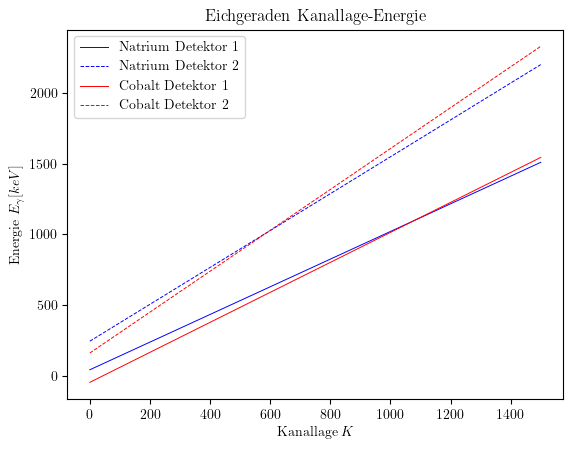

In [38]:
delta_E_na = peak('E','p2','na') - peak('E','p1','na') # Delta E

delta_D1_na = peak('D1','p2','na') - peak('D1','p1','na') # Delta K

b_D1_na = delta_E_na / delta_D1_na # determine b
a_D1_na = peak('E','p1','na') - b_D1_na * peak('D1','p1','na') # determine a

delta_D2_na = peak('D2','p2','na') - peak('D2','p1','na')
b_D2_na = delta_E_na / delta_D2_na 
a_D2_na = peak('E','p1','na') - b_D2_na * peak('D2','p1','na')


delta_E_co = peak('E','p2','co') - peak('E','p1','co')

delta_D1_co = peak('D1','p2','co') - peak('D1','p1','co') 
b_D1_co = delta_E_co / delta_D1_co
a_D1_co = peak('E','p1','co') - b_D1_co * peak('D1','p1','co')

delta_D2_co = peak('D2','p2','co') - peak('D2','p1','co')
b_D2_co = delta_E_co / delta_D2_co 
a_D2_co = peak('E','p1','co') - b_D2_co * peak('D2','p1','co')


multiindex2 = [
    ["D1", "D1", "D2", "D2"],
    ["a", "b", "a", "b"],
]
tuples = list(zip(*multiindex2))
index2 = pd.MultiIndex.from_tuples(tuples, names=["Detector","Calibration value"])
calibration = pd.DataFrame({"na":[a_D1_na,b_D1_na,a_D2_na,b_D2_na],
                       "co":[a_D1_co,b_D1_co,a_D2_co,b_D2_co]}, index=index2)

ic(calibration)

def calibrate(d,s,ch):
    '''
    d: detector, D1 or D2 
    s: source, na or co
    ch: channel value, float
    '''
    a = calibration.loc[(d,'a'),s]
    b = calibration.loc[(d,'b'),s]
    E = a + b*ch
    return E
ic(calibrate('D1','na',480)) # test

ch = np.linspace(0,1500,1000)
fig, ax = plt.subplots()
ax.plot(ch, calibrate('D1','na',ch), 'b', linewidth=.7, label='Natrium Detektor 1')
ax.plot(ch, calibrate('D2','na',ch), 'b--', linewidth=.7,label='Natrium Detektor 2')
ax.plot(ch, calibrate('D1','co',ch), 'r', linewidth=.7,label='Cobalt Detektor 1')
ax.plot(ch, calibrate('D2','co',ch), 'r--', linewidth=.7,label='Cobalt Detektor 2')
ax.set_title('Eichgeraden Kanallage-Energie')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Energie $E_\\gamma [keV]$ ')
ax.legend()
plt.show()

In [39]:
def calenergyplot(data, peak1, title, peak2=None, color1='g', color2='r'):
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'Kanal'
    df['counts'] = df.loc[df['counts'] > 0]
    sns.scatterplot(x=df.index, y=df['counts'], s=3, color='k')
    plt.title(title)
    if peak2 == None:
        plt.axvline(peak1, linewidth=.5, c=color1, label=f'peak bei {peak1}')
    else:
        plt.axvline(peak1, linewidth=.5, c=color1, label=f'peak1 bei {peak1}')
        plt.axvline(peak2, linewidth=.5, c=color2, label=f'peak2 bei {peak2}')
    
    plt.legend()
    # plt.savefig(f"plots/{title}.pdf")
    plt.show()

## Time delay spectra $\&$ time resolution

ic| mean: 1018.4141294708838, sigma: 100.37922301957995


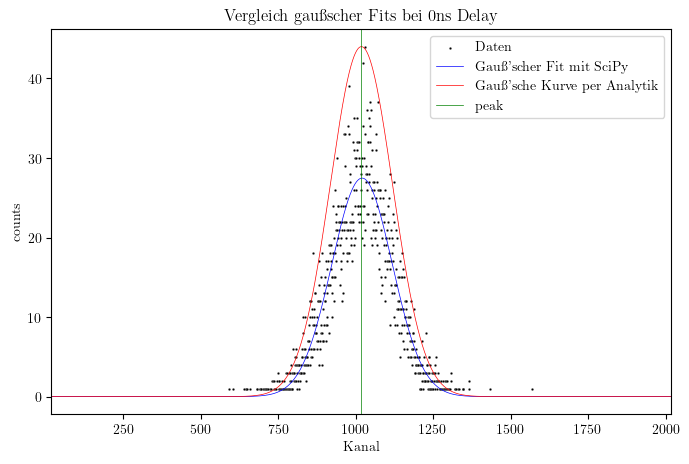

ic| mean: 1691.200889248181, sigma: 100.74068088404637


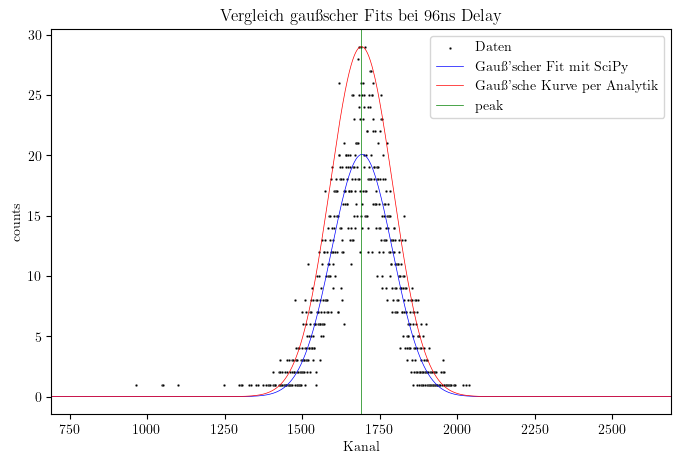

ic| timedifference: 672.7867597772972


The two delay modes have a peak difference of 672.7867597772972


In [40]:
def gaussian(x,y,mean,sigma): 
    return y * np.exp(-(x-mean)**2 / (2*sigma**2) )

peak=[]
def timedelayplot(data, title):
    # this function is actually not good, as it computes the mean, computes the gaussian and plots the function all in one. This reduces flexibility. 
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'Kanal'

    # computing gaussian parameters mu and sigma, required for both analytical and numerical fit
    y = df['counts']
    x = df.index
    mean = sum(y * x) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y) )
    ic(mean, sigma)
    peak.append(mean)

    # performing a gaussian fit
    popt,pcov = curve_fit(gaussian,x,y,p0=[max(y),mean,sigma])

    # plot
    fig, ax = plt.subplots(figsize=(8,5))
    df['counts'] = df.loc[df['counts'] > 0]
    sns.scatterplot(x=df.index, y=df['counts'], s=3, color='k', label='Daten')
    ax.plot(x, gaussian(x,*popt), 'b-', linewidth=.5, label=f'Gauß\'scher Fit mit SciPy')
    ax.plot(x, gaussian(x,y=df['counts'].max(),mean=mean,sigma=sigma), color='r', linewidth=.5, label='Gauß\'sche Kurve per Analytik')
    ax.axvline(mean, linewidth=.5, color='g', label='peak')
    ax.set_title(title)
    ax.set_xlim(mean-1000, mean+1000) 
    ax.legend()
    plt.savefig(f"plots/{title}.pdf")
    plt.show()

timedelayplot('Results/zeitspektrum_0nsdelay.asc','Vergleich gaußscher Fits bei 0ns Delay')
timedelayplot('Results/zeitspektrum_96nsdelay.asc','Vergleich gaußscher Fits bei 96ns Delay')

timedifference = peak[1]-peak[0] # the actual result
ic(timedifference)
print("The two delay modes have a peak difference of", timedifference)

- The manual curve (red) includes the maximal peak value $\textbf{at the cost of overestimating the overall count rate}$. Notice how most data points are under the curve.
- The fitted curve (blue) takes the variation of the count rate into account. Notice how the curve goes through the middle of the "width" of the data. It doesn't reach the maximal count value, but this is due to the large variation of count value at the mean channel value. \
Conclusion: the fitted plot is the more reliable one. 

In [41]:
'''
time resolution
'''

'\ntime resolution\n'

# Coincidence gamma spectroscopy
## Sodium annihilation radiation, angle at maximum signal strength

Values TOTALSUM and REALTIME taken from 'Results/4.1.4/*.mcd' files

In [42]:
ic(24/123.136)
ic(59/123.155)
ic(84/129.882)
ic(48/122.609)

ic| 24/123.136: 0.1949064449064449
ic| 59/123.155: 0.47907108927773945
ic| 84/129.882: 0.6467408878828474
ic| 48/122.609: 0.3914883899224364


0.3914883899224364

deflection| sum | time | count rate
:-   |-|-|:-
0cm  | 24 | 123.136s | 0.1949064449064449 $s^{-1}$
-1cm | 59 | 123.155s | 0.47907108927773945 $s^{-1}$
-2cm | 84 | 129.882s | 0.6467408878828474 $s^{-1}$
-3cm | 48 | 122.609s | 0.3914883899224364 $s^{-1}$

Maximal count rate at a deflection of -2cm.

## Sodium angular correlation between 
## $e^+e^- $ annihilation and $\gamma$-decay

## Cobalt decay cascade